### Audio Spectrogram Transformer, LoRA FineTuning

20307140044 李培基

In [43]:
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoFeatureExtractor, ASTForAudioClassification, AutoModelForAudioClassification, AutoConfig
from torch.optim import AdamW
from peft import LoraConfig, get_peft_model
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

### 数据集处理与模型初始化

In [71]:
device = 'cuda:3'
torch.set_float32_matmul_precision("high")
sampling_rate = 16000 # 这个数据集本来就是16000采样率
ds = load_dataset("MLCommons/ml_spoken_words", languages=["zh-CN"])
ds = ds.remove_columns(["file", 'is_valid',"language", "speaker_id", 'gender']) # 已检查，全部valid
train_set = ds['train']
val_set = ds['validation']
test_set = ds['test']
labels = []
# 检查数据集合法性
worddict = {}
for item in train_set:
    worddict[item['keyword']] = 1
for item in val_set:
    assert worddict[item['keyword']] == 1
for item in test_set:
    assert worddict[item['keyword']] == 1
for item in worddict:
    labels.append(item)

# 构建标签与数字的映射关系
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
print(label2id)
print(id2label)
num_labels = len(id2label)

# ml_spoken_words数据集长度为1秒，根据论文,可以设置 max_length = 100t = 100
# 不设置此参数，将会全部自动padding到1024，相当于10秒的长度，是默认根据在AudioSet的10秒数据集上训练的
# feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593",max_length = 100)
# model = AutoModelForAudioClassification.from_pretrained(
#     "MIT/ast-finetuned-audioset-10-10-0.4593", num_labels=num_labels, label2id=label2id, id2label=id2label,
#     ignore_mismatched_sizes=True, max_length = 100
# )

# 使用这段代码，则随机初始化权重
# config = AutoConfig.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593",
#                                     num_labels=num_labels, label2id=label2id, id2label=id2label,
#                                     ignore_mismatched_sizes=True)
# model = AutoModelForAudioClassification.from_config(config)

# 使用这段代码，是在1秒长度数据集SpeechCommand上预训练的，这个配置中max_length = 128
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-speech-commands-v2")
model = AutoModelForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-speech-commands-v2", num_labels=num_labels, label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True
)

# dataloader的collate_fn
def mlc_collate_fn(data):
    batch = {}
    # batch['keyword'] = [d['keyword'] for d in data]
    batch['labels'] = torch.tensor([label2id[d['keyword']] for d in data]).to(device)
    batch['input_values'] = torch.cat(
            [feature_extractor(d['audio']['array'], sampling_rate=sampling_rate, return_tensors="pt").input_values for d in data]).to(device) # a tensor of arrays return batch
    return batch

# 打印模型参数量以及可训练参数量
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )


Found cached dataset ml_spoken_words (/remote-home/pjli/.cache/huggingface/datasets/MLCommons___ml_spoken_words/zh-CN_wav-6e7818d76df98faf/1.0.0/321ea853cf0a05abb7a2d7efea900692a3d8622af65a2f3ce98adb7800a5d57b)
100%|██████████| 3/3 [00:00<00:00, 491.64it/s]


{'一些': 0, '三十四': 1, '三尖杉': 2, '三峡': 3, '三年': 4, '三维': 5, '上述': 6, '下表': 7, '不丹': 8, '不明': 9, '世代': 10, '世宗': 11, '东京': 12, '东侧': 13, '东南': 14, '东正教': 15, '东部': 16, '严谨': 17, '中举': 18, '为期': 19, '为首': 20, '主任委员': 21, '主体': 22, '主办': 23, '主线': 24, '主题曲': 25, '之中': 26, '乌头属': 27, '乔治亚州': 28, '乘客': 29, '九龙': 30, '争议': 31, '事务所': 32, '二十一': 33, '二氧化碳': 34, '于是': 35, '交会': 36, '交界': 37, '产于': 38, '人类': 39, '人类学': 40, '介面': 41, '任意': 42, '任职': 43, '众多': 44, '优良': 45, '传奇': 46, '传记': 47, '伴随': 48, '例如': 49, '供应': 50, '俄国': 51, '保加利亚': 52, '信用': 53, '俱乐部': 54, '偏好': 55, '停止': 56, '元素': 57, '光滑': 58, '兖州': 59, '入口': 60, '入境': 61, '入球': 62, '全市': 63, '八旗': 64, '公元': 65, '公司': 66, '公学': 67, '公家': 68, '兰德': 69, '关押': 70, '其实': 71, '具有': 72, '内尔': 73, '内战': 74, '内蒙古': 75, '军政': 76, '农业部': 77, '农场': 78, '凯尔': 79, '出使': 80, '出没': 81, '击败': 82, '分别': 83, '分子': 84, '分开': 85, '刑事': 86, '列表': 87, '初中': 88, '删除': 89, '剧场': 90, '副作用': 91, '努力': 92, '北海道': 93, '医师': 94, '十五': 95, '十八年': 96, '十字': 97, '十字花科':

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-speech-commands-v2 and are newly initialized because the shapes did not match:
- classifier.dense.weight: found shape torch.Size([35, 768]) in the checkpoint and torch.Size([498, 768]) in the model instantiated
- classifier.dense.bias: found shape torch.Size([35]) in the checkpoint and torch.Size([498]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 预处理后的频域图可视化

torch.Size([128, 128])


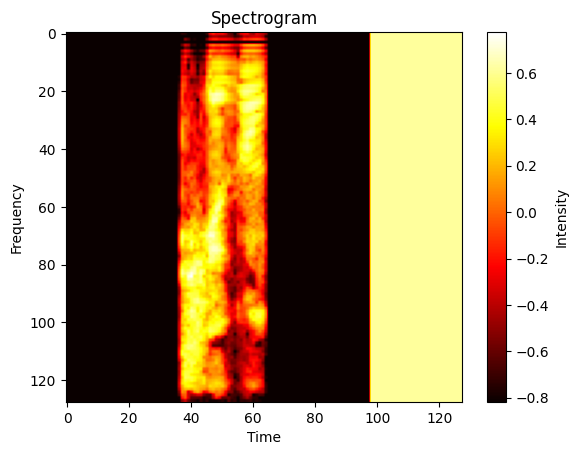

In [72]:
dataloader = DataLoader(dataset=train_set, batch_size=1, shuffle=True, collate_fn = mlc_collate_fn)
spectrogram = next(iter(dataloader))['input_values'].squeeze(0).permute(1,0).to('cpu')
print(spectrogram.shape)
# 可视化频谱图
plt.imshow(spectrogram, cmap='hot', aspect='auto')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Intensity')
plt.title('Spectrogram')
plt.show()


### 执行这段代码则使用LoRA包装模型

In [60]:
# 配置LoRA
config = LoraConfig(
    r=16,
    lora_alpha=256,
    target_modules=["query", "value","key"],
    lora_dropout=0.2,
    bias="none",
    modules_to_save=["classifier"]
)
model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 1653732 || all params: 87020772 || trainable%: 1.90


### 设置训练参数

In [73]:
train_loader = DataLoader(dataset=train_set, batch_size=128, shuffle=True, collate_fn = mlc_collate_fn)
val_loader = DataLoader(dataset=val_set, batch_size=128, shuffle=True, collate_fn = mlc_collate_fn)
test_loader = DataLoader(dataset=test_set, batch_size=128, shuffle=True, collate_fn = mlc_collate_fn)

model.to(device)
epochs = 30
best_acc = 0
save_path = 'bestmodel.pth'
optimizer = AdamW(model.parameters(),lr = 5e-4)
print_trainable_parameters(model)

trainable params: 85751538 || all params: 85751538 || trainable%: 100.00


### 执行训练

In [ ]:
# 训练与验证
for epoch in range(epochs):
    for batch_idx, batch in tqdm(enumerate(train_loader)):
        model.train()
        output = model(**batch)
        pred = output.logits.argmax(-1)
        labels = batch['labels']
        loss = output.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # 打印
    with torch.no_grad():
        train_acc = torch.sum(pred == labels)/pred.shape[0]
        print('train loss:',loss.item(),'train acc:',train_acc.item())
        # 验证
        model.eval()
        correct = 0
        total = 0
        for batch_idx, batch in enumerate(val_loader):
            output = model(**batch)
            pred = output.logits.argmax(-1)
            labels = batch['labels']
            correct += (torch.sum(pred == labels)).item()
            total += pred.shape[0]
        val_acc = correct/total
        print('val_acc:',val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print('best parameters on validation set saved')



### 测试

In [75]:
# 测试

cnt = 0
pos = 0
model = AutoModelForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593", num_labels=num_labels, label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True
)
model = get_peft_model(model,config)
model.to(device)
model.load_state_dict(torch.load(save_path))
model.eval()
with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(test_loader)):
        output = model(**batch)
        pred = output.logits.argmax(-1)
        labels = batch['labels']
        pos += (torch.sum(pred == labels)).item()
        cnt += pred.shape[0]

10it [00:03,  2.71it/s]


In [76]:
print('acc on test set:',pos/cnt)

acc on test set: 0.7126623376623377


##### 执行以下代码清空显存

In [9]:
import os
pid = os.getpid()
print(pid)
!kill -9 $pid

7496


: 

: 